In [45]:
from pepdata.amino_acid_alphabet import canonical_amino_acid_letters


filename="class1_sequences.csv"
allow_unknown_amino_acids=True
add_start_token=True
add_stop_token=True
include_tap_genes = False

df = pd.read_csv(filename)
if not include_tap_genes:
    tap_mask = df.gene.str.startswith("TAP")
    df = df[~tap_mask]
    
mhc_sequences = df.seq
labels = df.species_prefix

token_order = {t: i + 1 for i, t in enumerate(canonical_amino_acid_letters)}
token_order["-"] = 0
n_tokens = 21

if allow_unknown_amino_acids:
    mhc_sequences = mhc_sequences.str.replace("?", "X")
    token_order["X"] = n_tokens
    n_tokens += 1

if add_start_token:
    mhc_sequences = "^" + mhc_sequences
    token_order["^"] = n_tokens
    n_tokens += 1

if add_stop_token:
    mhc_sequences = mhc_sequences + "$"
    token_order["$"] = n_tokens
    n_tokens += 1


max_seq_len = mhc_sequences.str.len().max()
print("Max MHC seq len: %d" % max_seq_len)
def pad_seq(s):
    n_padded_chars_needed = max_seq_len - len(s)
    result = s + ("-" *  n_padded_chars_needed) 
    assert len(result) == max_seq_len
    return result
                  
padded_mhc_sequences = mhc_sequences.map(pad_seq)
n_samples = len(padded_mhc_sequences)
encoded_sequences = np.zeros(
    (n_samples, max_seq_len), dtype="int32")
for i, s in enumerate(padded_mhc_sequences):
    encoded_sequences[i, :] = [token_order[si] for si in s]

unique_labels = list(set(labels.unique()))
label_order = {s: i for (i, s) in enumerate(unique_labels)}
encoded_labels = labels.map(lambda s: label_order[s]).values


n_labels = len(label_order)



Max MHC seq len: 403


In [46]:
df[df.seq.str.len() > 400]

,species_prefix,gene,allele,seq,id
14267,SLA,7,02:01,MGPQALLLLLSGTLVLTQPWARPHSLRYFYTAVSRPSRRDPRFSVV...,IPD-MHC:SLA08518


In [48]:
encoded_labels_onehot = np.zeros((n_samples, n_labels), dtype="int32")
for row_idx, label_idx in enumerate(encoded_labels):
    encoded_labels_onehot[row_idx, label_idx] = 1


In [49]:
label_order

{'Popy': 0,
 'SLA': 1,
 'DLA': 2,
 'Pipi': 3,
 'Sasa': 4,
 'Sage': 5,
 'Papa': 6,
 'Lero': 7,
 'Maar': 8,
 'Cemi': 9,
 'Atbe': 10,
 'Paan': 11,
 'Ovar': 12,
 'Pacy': 13,
 'Chae': 14,
 'Patr': 15,
 'Eqca': 16,
 'Atfu': 17,
 'Caja': 18,
 'HLA': 19,
 'Saoe': 20,
 'Mafa': 21,
 'BoLA': 22,
 'Sasc': 23,
 'Hyla': 24,
 'Safu': 25,
 'Onmy': 26,
 'H-2': 27,
 'Mane': 28,
 'Paha': 29,
 'Mamu': 30,
 'Samy': 31,
 'Gogo': 32}

In [50]:

encoded_labels

array([19, 19, 19, ..., 27, 27, 27])

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)



In [52]:
import pytorch_lightning as pl

In [70]:
from torch.utils.data import random_split, TensorDataset, DataLoader
from torch.optim import Adam 

class SpeciesClassifier(pl.LightningModule):
    def __init__(
            self,
            n_tokens,
            n_labels,
            embedding_dim=32,
            lstm_hidden_dim=128,
            batch_size=64,
            lr=1e-3):
        super(SpeciesClassifier, self).__init__()
        self.n_tokens = n_tokens
        self.n_labels = n_labels
        self.lr = lr
        
        self.embedding_dim = embedding_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.batch_size = batch_size

        self.embeddings = nn.Embedding(n_tokens, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim)
        self.linear_classify = nn.Linear(lstm_hidden_dim, n_labels)

    def forward(self, x):
        batch_size, max_len = x.size()
        embedded = self.embeddings(x)        
        lstm_out, _  = self.lstm(embedded)
        label_weights = self.linear_classify(lstm_out[:, -1, :].view(batch_size, -1))
        label_scores = F.log_softmax(label_weights, dim=1)
        return label_scores
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        return {'val_loss': loss}

    def prepare_data(self):
        self.X = torch.from_numpy(encoded_sequences).long()
        self.y = torch.from_numpy(encoded_labels).long()
        self.dataset = TensorDataset(self.X, self.y)
        self.n_total = len(self.X)
        self.n_train = int(0.66 * self.n_total)
        self.n_val = int(0.1 * self.n_total)
        self.n_test = (self.n_total - self.n_train) - self.n_val
        (self.dataset_train, self.dataset_val, self.dataset_val) = \
            random_split(self.dataset, [self.n_train, self.n_val, self.n_test])
        
    def train_dataloader(self):
        return DataLoader(self.dataset_train, num_workers=2, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, num_workers=2, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False)

    def configure_optimizers(self):
        print("LR", self.lr)
        optimizer = Adam(self.parameters(), lr=self.lr)
        return optimizer

# train
model = SpeciesClassifier(n_tokens, n_labels)

     

In [71]:

trainer = pl.Trainer(auto_lr_find=True, max_epochs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



  | Name            | Type      | Params
----------------------------------------------
0 | embeddings      | Embedding | 768   
1 | lstm            | LSTM      | 82 K  
2 | linear_classify | Linear    | 4 K   


LR 0.001


/usr/local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


Best LR 0.00478630092322638



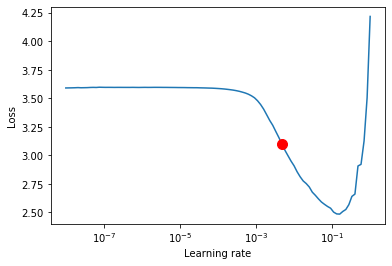

In [72]:
# Run learning rate finder
lr_finder = trainer.lr_find(model)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print("Best LR", new_lr)
# update hparams of the model
model.lr = new_lr


In [73]:
trainer.fit(model)



  | Name            | Type      | Params
----------------------------------------------
0 | embeddings      | Embedding | 768   
1 | lstm            | LSTM      | 82 K  
2 | linear_classify | Linear    | 4 K   


LR 0.00478630092322638


LR finder stopped early due to diverging loss.
/usr/local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You're resuming from a checkpoint that ended mid-epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint. 
  warnings.warn(*args, **kwargs)
Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pytorch_lightning/trainer/lr_finder.py", line 352, in suggestion
    min_grad = np.gradient(loss).argmin()
  File "<__array_function__ internals>", line 6, in gradient
  File "/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py", line 1042, in gradient
    "Shape of array too small to calculate a numerical gradient, "
ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Learning rate set to None


LR None


TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [39]:
classifier(X_tensor[:32, :]).size()

torch.Size([32, 403, 128])


torch.Size([32, 33])

In [67]:
new_lr

0.003311311214825908